# Training Set Analysis
The purpose of this notebook is to compute the kernel density estimate of the PDF between the judgement and each feature in a training set, in order to estimate how each feature is performing.

# TODO
Modify features to use custom function score queries, and use ML to optimise features given the below plot (plot ideal relationship between judgement and features, and optimise to get as close as possible).

In [46]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pylab as plt

models_dir = "/Users/sullid/ONS/dp-search-service/src/main/resources/elastic.ltr/models"
model_name = "ons_1516121421115"

In [47]:
class TrainingData(object):
    """
    Class to handle the loading of training sets
    """
    def __init__(self, model_dir, model_name):
        self.model_dir = model_dir
        self.model_name = model_name
    
        self.data = {}
        self.load()
        
    def load(self):
        fname = "%s/%s/ons_train.txt" % (self.model_dir, self.model_name)
        with open(fname, 'r') as f:
            lines = f.readlines()
            
            qid_dict = {}
            # First collect the qids
            for line in lines:
                parts = line.split("\t")
                qid_part = parts[1]
                qid = int(qid_part.split(":")[1])
                if (qid not in qid_dict):
                    qid_dict[qid] = []
                qid_dict[qid].append(line)
                
            # Process each line by the qid
            for qid in qid_dict.keys():
                lines = qid_dict[qid]
                self.data[qid] = {}
                for line in lines:
                    if (line.startswith("#")):
                        continue
                    parts = line.split("\t")
                    if (len(parts) > 0):
                        for part in parts:
                            if ('#' in part):
                                part = part[0:part.index("#")].strip()
                            key = "J"
                            val = 0.0
                            if (":" in part):
                                key = part.split(":")[0]
                                val = float(part.split(":")[-1])
                            else:
                                val = float(part)
                            if (key not in self.data[qid]):
                                self.data[qid][key] = []
                            self.data[qid][key].append(val)
                        
    def get(self, qid, item):
        return np.array(self.data[qid][item])
    
    def keys(self, qid):
        return self.data[qid].keys()
    
    def min(self, qid, item):
        return min(self.get(qid, item))
    
    def max(self, item):
        return max(self.get(qid, item))
    
    def size(self, qid):
        return len(self.get(qid, "J"))
    
    def numFeatures(self, qid):
        return len(self.keys(qid)) - 2  # - 2 to account for judgement (J) and qid
    
trainingData = TrainingData(models_dir, model_name)

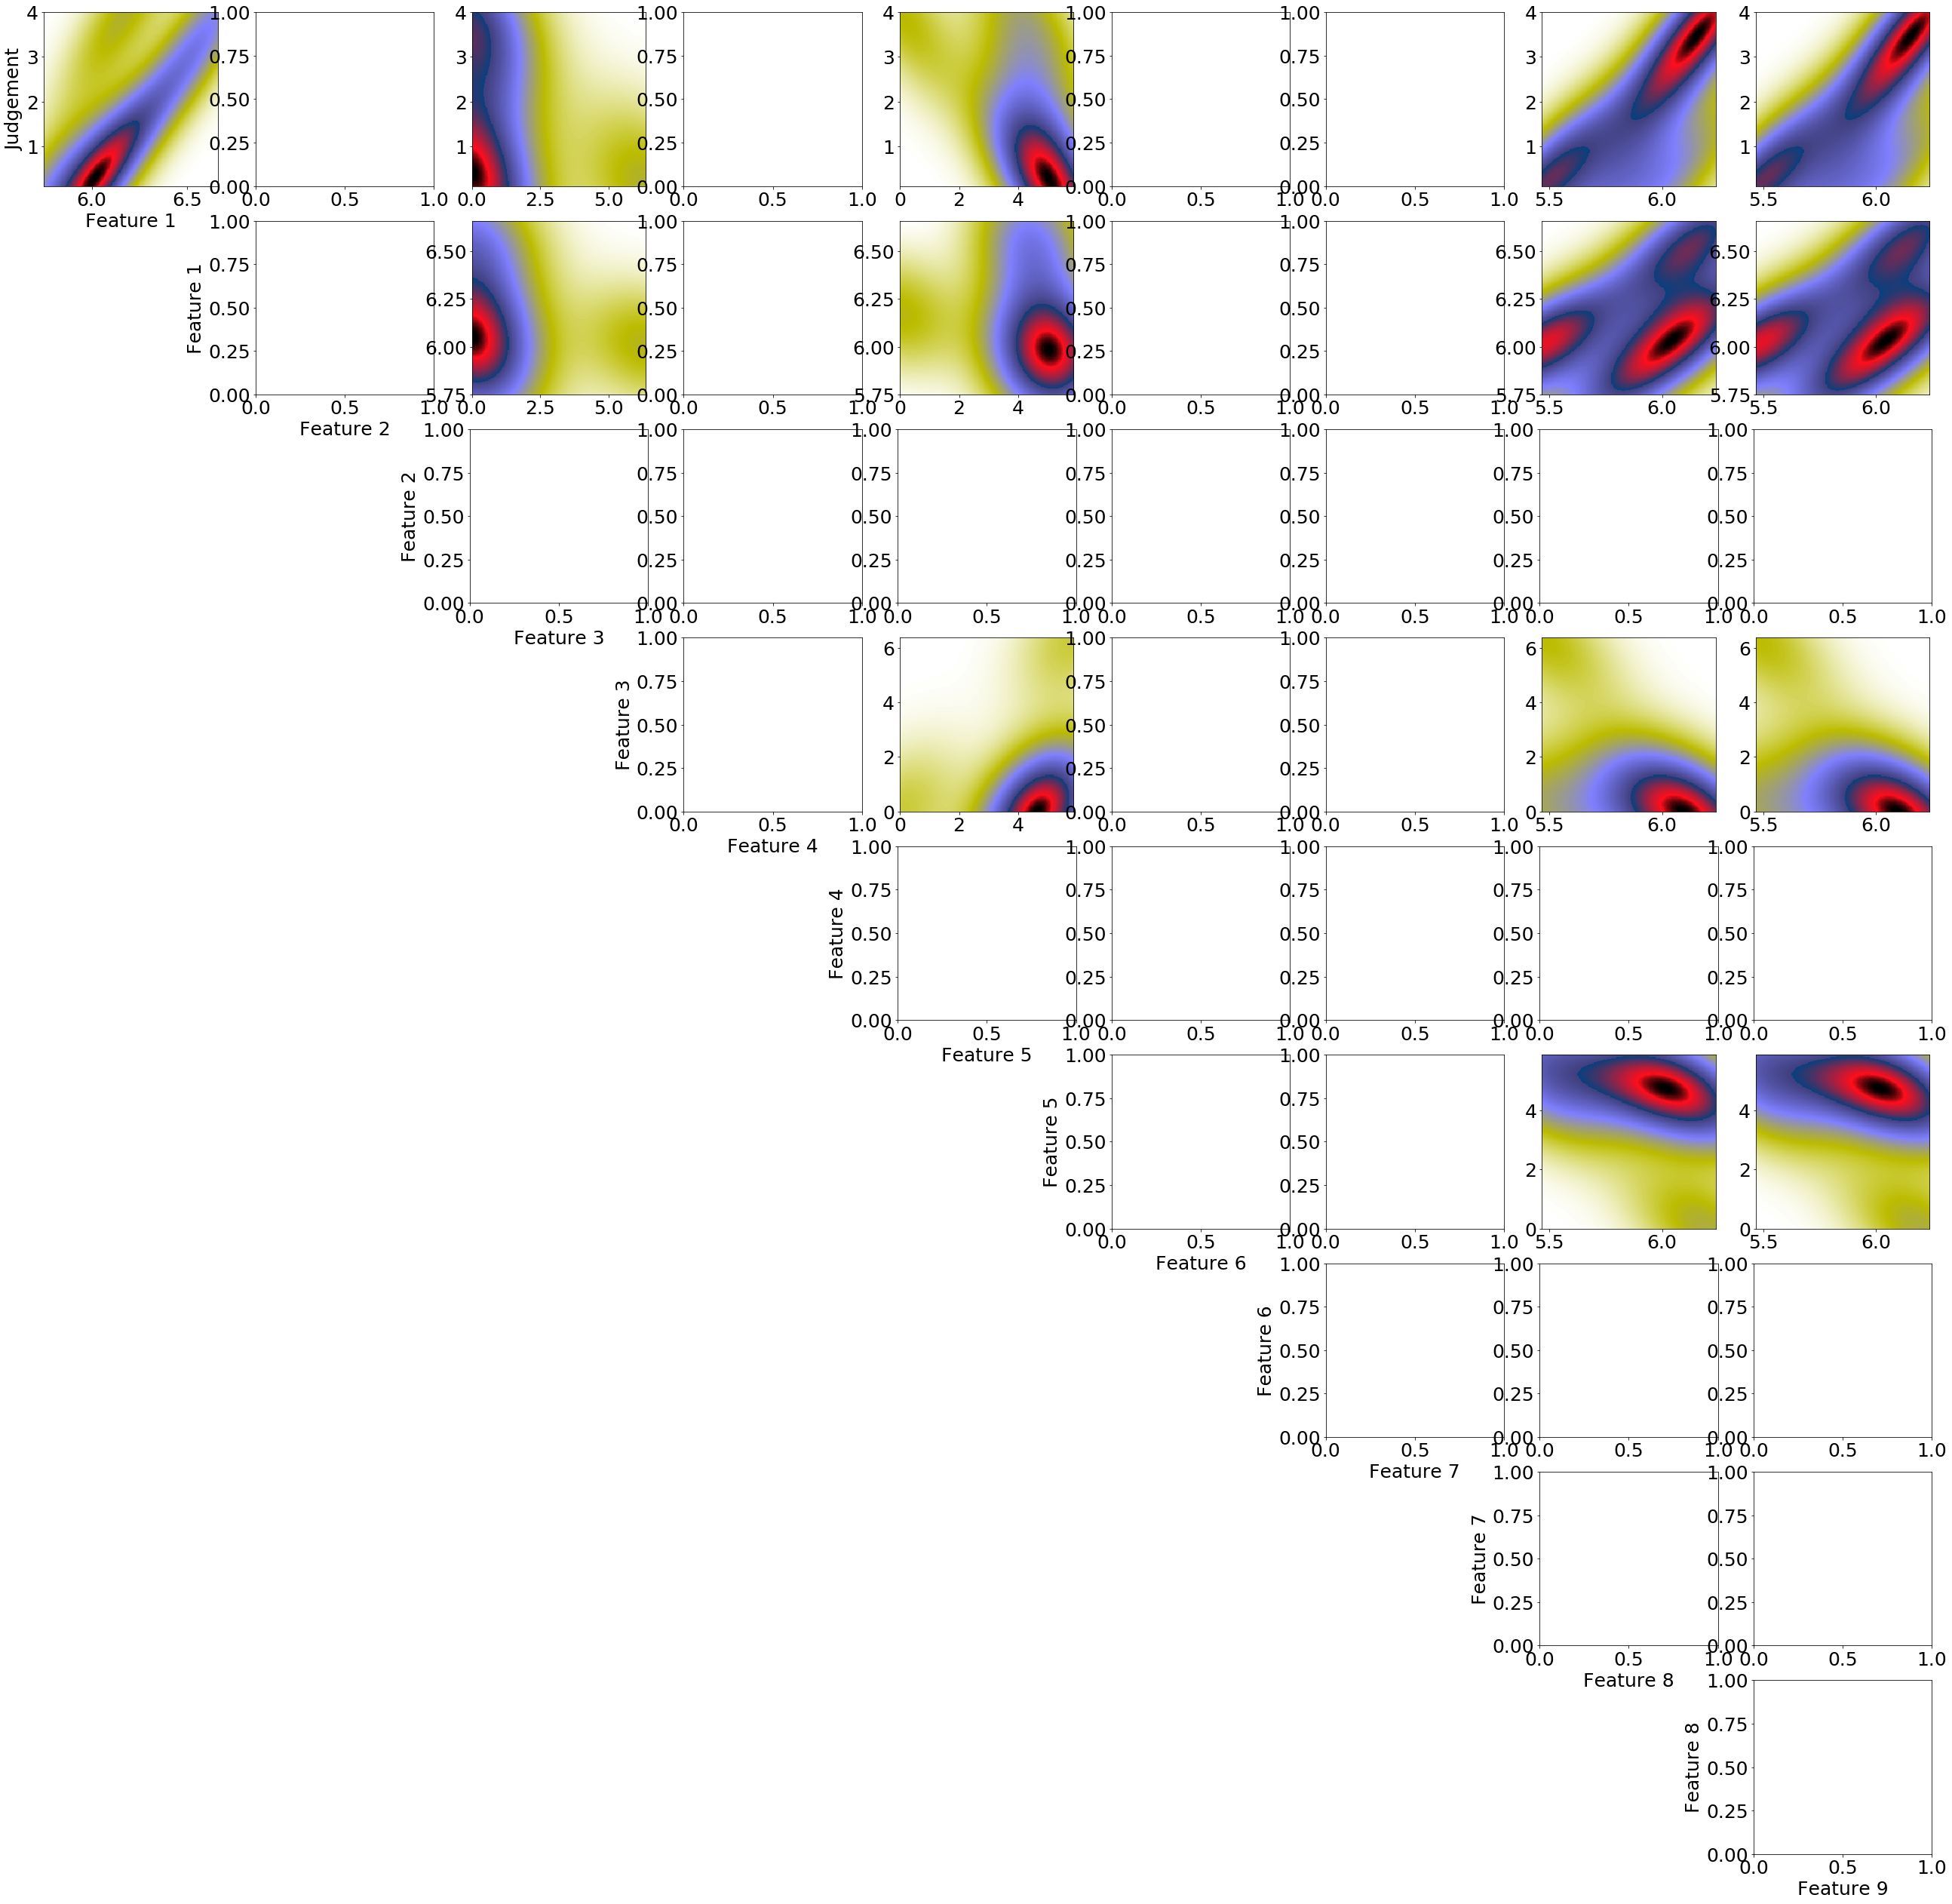

In [48]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
fs=25
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': fs,
         'axes.titlesize':fs,
         'xtick.labelsize':fs,
         'ytick.labelsize':fs}
pylab.rcParams.update(params)

qid = 1

def getValues(trainingData, qid, i):
    if (i == 0):
        return "Judgement", trainingData.get(qid, "J")
#     elif (i == 1 or i == 9):
#         return str(i), np.log10(trainingData[str(i)])
    else:
        return "Feature %d" % i, trainingData.get(qid, str(i))
    
def fitKernel(x,y,n=100j):
    xmin,xmax,ymin,ymax=(x.min(),x.max(),y.min(),y.max())

    X, Y = np.mgrid[xmin:xmax:n, ymin:ymax:n]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return np.rot90(Z), (xmin, xmax, ymin, ymax)

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

numFeatures = trainingData.numFeatures(qid) + 1

fig = plt.figure(figsize=(50, 50))
gs = gridspec.GridSpec(numFeatures, numFeatures)

for i in range(numFeatures):
    rowLabel, rowValues = getValues(trainingData, qid, i)
    labelRow = True
    for j in range(i+1, numFeatures):
        colLabel, colValues = getValues(trainingData, qid, j)
        
        ax = plt.subplot(gs[i,j-numFeatures])

#         ax.text(0.25, 0.5, "ax %d:%d" % (i,j))
        if (labelRow):
            ax.set_ylabel(rowLabel)
            labelRow = False
        if (j == (i+1)):
            ax.set_xlabel(colLabel)
        
        try:
            Z, (xmin,xmax,ymin,ymax) = fitKernel(colValues, rowValues, 200j)
            extent = [xmin,xmax,ymin,ymax]
            ax.imshow(Z, cmap=plt.cm.gist_stern_r, extent=extent)
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            forceAspect(ax)
        except:
            pass
        

# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
#           extent=[xmin, xmax, ymin, ymax], aspect=50)
# ax.plot(x, y, 'k.', markersize=2)
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
plt.show()